In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
%matplotlib inline

In [3]:
data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/test.csv')

### Split

In [4]:
X = data_train[data_train.columns.difference(['Price'])]
y = data_train.Price
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 9254 to 7270
Data columns (total 19 columns):
DistrictId       8000 non-null int64
Ecology_1        8000 non-null float64
Ecology_2        8000 non-null object
Ecology_3        8000 non-null object
Floor            8000 non-null int64
Healthcare_1     4148 non-null float64
Helthcare_2      8000 non-null int64
HouseFloor       8000 non-null float64
HouseYear        8000 non-null int64
Id               8000 non-null int64
KitchenSquare    8000 non-null float64
LifeSquare       6299 non-null float64
Rooms            8000 non-null float64
Shops_1          8000 non-null int64
Shops_2          8000 non-null object
Social_1         8000 non-null int64
Social_2         8000 non-null int64
Social_3         8000 non-null int64
Square           8000 non-null float64
dtypes: float64(7), int64(9), object(3)
memory usage: 1.2+ MB


### Plots functions

In [5]:
def square_lifesquare(ds):
    plt.xlabel('Square')
    plt.ylabel('Life Square')
    plt_ = plt.scatter(ds.Square, ds.LifeSquare)

In [6]:
def floor_housefloor(ds):
    plt.xlabel('House Floor')
    plt.ylabel('Floor')
    plt_ = plt.scatter(ds.HouseFloor, ds.Floor)

In [7]:
def housefloor_year(ds):
    plt.ylabel('HouseFloor')
    plt.xlabel('HouseYear')
    plt_ = plt.scatter(ds.HouseYear, ds.HouseFloor)

In [8]:
def housefloor_floor(ds):
    plt.xlabel('HouseFloor')
    plt.ylabel('Floor')
    plt_ = plt.scatter(ds.HouseFloor, ds.Floor)

### Data preparing

#### Simple functions (no mean or any statistics)

In [9]:
def set_dummies(ds):
    return pd.get_dummies(ds)

In [10]:
def fill_lifesquare(ds):
    ds.LifeSquare = ds.LifeSquare.fillna(1)
    ds.LifeSquare = np.where((ds.LifeSquare < 8) | (ds.LifeSquare > ds.Square), ds.Square, ds.LifeSquare)
    return ds

In [11]:
def clear_year(ds):
    ds.HouseYear = np.where(ds.HouseYear > 2020, 2020, ds.HouseYear)
    ds.HouseYear = np.where(ds.HouseYear < 1900, 1900, ds.HouseYear)
    return ds

In [12]:
def set_floors(ds):
    ds.HouseFloor = np.where(ds.HouseFloor == 0, ds['mean_hfloor_year_dist'], ds.HouseFloor)
    ds.Floor = np.where(ds.Floor > ds.HouseFloor, ds.HouseFloor, ds.Floor)
    ds.Floor = np.where(ds.Floor == 0, 1, ds.Floor)
    return ds

#### Statictics, merging

Price stats for DistrictId, HouseYear

In [13]:
X_with_price = X_train.copy()
X_with_price.loc[:, 'Price'] = y_train
# mean_price_districtid
s12 = X_with_price.groupby(['DistrictId'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price_districtid'})
# mean_price_houseyear
s13 = X_with_price.groupby(['HouseYear'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price_houseyear'})

def price_hyear_dist_stat(ds):
    ds = pd.merge(ds, s12, on=['DistrictId'], how='left')
    ds = pd.merge(ds, s13, on=['HouseYear'], how='left')
    ds['mean_price_districtid'] = ds['mean_price_districtid'].fillna(s12['mean_price_districtid'].mean())
    ds['mean_price_houseyear'] = ds['mean_price_houseyear'].fillna(s13['mean_price_houseyear'].mean())
    return ds

Price for one square meter

In [14]:
X_with_price = X_train.copy()
X_with_price.loc[:, 'Price'] = y_train

# mean_sq_dist_hyear
s21 = X_with_price.groupby(['DistrictId', 'HouseYear'], as_index=False)[['Square']].mean().rename(columns={'Square':'mean_sq_dist_hyear'})
# mean_sq_dist
s22 = X_with_price.groupby(['DistrictId'], as_index=False)[['Square']].mean().rename(columns={'Square':'mean_sq_dist'})
# mean_sq_hyear
s23 = X_with_price.groupby(['HouseYear'], as_index=False)[['Square']].mean().rename(columns={'Square':'mean_sq_hyear'})

def square_hyear_dist_stat(ds):
    ds = pd.merge(ds, s21, on=['DistrictId', 'HouseYear'], how='left')
    ds = pd.merge(ds, s22, on=['DistrictId'], how='left')
    ds = pd.merge(ds, s23, on=['HouseYear'], how='left')
    ds['mean_sq_dist_hyear'] = ds['mean_sq_dist_hyear'].fillna(s21['mean_sq_dist_hyear'].mean())
    ds['mean_sq_dist'] = ds['mean_sq_dist'].fillna(s22['mean_sq_dist'].mean())
    ds['mean_sq_hyear'] = ds['mean_sq_hyear'].fillna(s23['mean_sq_hyear'].mean())
    return ds

HouseFloor stats for Year, DistrictId

In [15]:
nice_ = X_train[(X_train.HouseFloor > 0) & (X_train.HouseFloor < 40)]
# mean_hfloor_year_dist
s31 = nice_.groupby(['DistrictId', 'HouseYear'], as_index=False)[['HouseFloor']].mean().rename(columns={'HouseFloor':'mean_hfloor_year_dist'})

def hfloor_hyear_dist_stat(ds):
    ds = pd.merge(ds, s31, on=['HouseYear', 'DistrictId'], how='left')
    ds['mean_hfloor_year_dist'] = ds['mean_hfloor_year_dist'].fillna(s31['mean_hfloor_year_dist'].mean())
    return ds

In [16]:
def prepare(ds):
    ds = set_dummies(ds)
    ds = fill_lifesquare(ds)
    ds = clear_year(ds)
    
    ds = price_hyear_dist_stat(ds)
    ds = hfloor_hyear_dist_stat(ds)
    ds = square_hyear_dist_stat(ds)
    
    ds = set_floors(ds)
    
    return ds

In [17]:
X_train = prepare(X_train)
X_valid = prepare(X_valid)

#### Visual analisis after data preparation

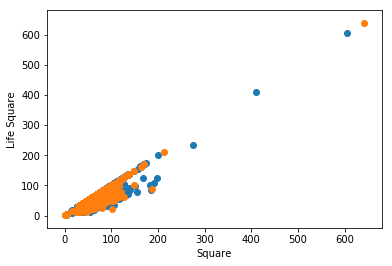

In [18]:
square_lifesquare(X_train)
square_lifesquare(X_valid)

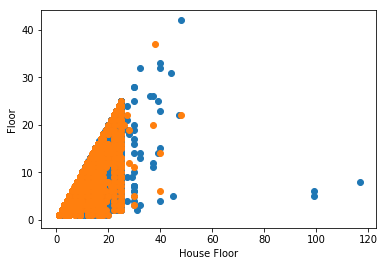

In [19]:
floor_housefloor(X_train)
floor_housefloor(X_valid)

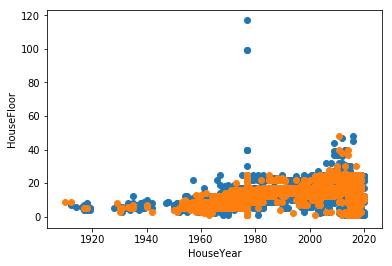

In [20]:
housefloor_year(X_train)
housefloor_year(X_valid)

In [21]:
X_train.HouseYear.describe()

count    8000.000000
mean     1984.962875
std        18.372376
min      1912.000000
25%      1974.000000
50%      1977.000000
75%      2001.000000
max      2020.000000
Name: HouseYear, dtype: float64

### Model

In [51]:
feats_original = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'Floor',
         'HouseFloor', 'HouseYear', 'Ecology_1',
         'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']
feats_dummies = ['Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

feats_stat_price = ['mean_price_districtid', 'mean_price_houseyear']
feats_stat_price_unit = ['mean_sq_dist', 'mean_sq_hyear']
feats_stat_floor = ['mean_hfloor_year_dist']
feats_stat = feats_stat_price + feats_stat_price_unit

feats = feats_original + feats_dummies + feats_stat

#### RandomForestRegressor

In [52]:
model = RandomForestRegressor(max_depth=12, random_state=42, n_estimators=50)
model.fit(X_train.loc[:, feats], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [53]:
def get_prediction(ds, y=None, r2=False):
    pred = model.predict(ds.loc[:, feats])
    if r2:
        print('R2:', r2_score(y, pred))
    return pred

In [54]:
pred_train = get_prediction(ds=X_train, y=y_train, r2=True)

R2: 0.9249459417336625


In [55]:
pred_valid = get_prediction(ds=X_valid, y=y_valid, r2=True)

R2: 0.7241390278388775


### test.csv

In [27]:
data_test = prepare(data_test)

In [28]:
data_test['Price'] = get_prediction(data_test)

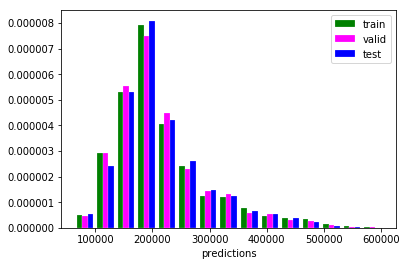

In [29]:
fig, ax = plt.subplots(1, 1)
hist_data = (pred_train, pred_valid, data_test.Price)
color = ['green', 'fuchsia', 'blue']
h_ = ax.hist(hist_data, bins=15, density=1, color=color, edgecolor='white', linewidth=0.2)
ax.set_xlabel('predictions')
ax.legend(('train', 'valid', 'test'), loc='upper right')
None

In [30]:
# data_test.loc[:, ['Id', 'Price']].to_csv('./data/YZinovev_predictions.csv', index=False)